In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from vcub_keeper.config import NON_USE_STATION_ID, ROOT_DATA_CLEAN
from vcub_keeper.reader.reader import read_time_serie_activity
from vcub_keeper.reader.reader_utils import filter_periode
from vcub_keeper.transform.features_factory import get_consecutive_no_transactions_out, process_data_cluster
from vcub_keeper.visualisation import plot_station_activity

sns.set_style("whitegrid")
%matplotlib inline

%load_ext autoreload
%autoreload 2

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Objectifs 

- Utilsation d'autres méthodes de détection d'anoamlie que Isolation Forest

## LocalOutlierFactor

In [7]:
from sklearn.neighbors import LocalOutlierFactor

In [52]:
# Lecture du fichier activité
STATION_ID = 106  # Victoire
FEATURES_TO_USE = ["consecutive_no_transactions_out", "Sin_weekday", "Cos_weekday", "Sin_hours", "Cos_hours"]
ts_activity = read_time_serie_activity(path_directory=ROOT_DATA_CLEAN)

ts_activity = get_consecutive_no_transactions_out(ts_activity)
# ts_activity = ts_activity[ts_activity['station_id'] == STATION_ID]
ts_activity = ts_activity.filter(pl.col("station_id") == STATION_ID)

In [53]:
# Feature engi for cluster
X = process_data_cluster(ts_activity)

# Filter data based on time & event
X = filter_periode(X, non_use_station_id=NON_USE_STATION_ID)
X = X.collect().to_pandas()

In [54]:
X.head()

,station_id,date,available_stands,available_bikes,status,transactions_in,transactions_out,transactions_all,consecutive_no_transactions_out,quarter,weekday,hours,Sin_quarter,Cos_quarter,Sin_weekday,Cos_weekday,Sin_hours,Cos_hours
0,106,2018-12-01 00:10:00,18,20,1,0,0,0,1,4,6,0,-2.449294e-16,1.0,-0.781831,0.62349,0.0,1.0
1,106,2018-12-01 00:20:00,15,23,1,3,0,3,2,4,6,0,-2.449294e-16,1.0,-0.781831,0.62349,0.0,1.0
2,106,2018-12-01 00:30:00,14,24,1,1,0,1,3,4,6,0,-2.449294e-16,1.0,-0.781831,0.62349,0.0,1.0
3,106,2018-12-01 00:40:00,14,24,1,2,2,4,0,4,6,0,-2.449294e-16,1.0,-0.781831,0.62349,0.0,1.0
4,106,2018-12-01 00:50:00,13,25,1,1,0,1,1,4,6,0,-2.449294e-16,1.0,-0.781831,0.62349,0.0,1.0


In [55]:
# Scaler
clf_scaler = StandardScaler()
# clf_scaler = RobustScaler()
clf_cluster = LocalOutlierFactor(n_neighbors=2, novelty=True)

pipe = Pipeline([("scale", clf_scaler), ("pca", PCA(n_components=0.9)), ("cluster", clf_cluster)])
pipe.fit(X[FEATURES_TO_USE])

Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA(n_components=0.9)),
                ('cluster', LocalOutlierFactor(n_neighbors=2, novelty=True))])

In [56]:
X["anomaly"] = pipe.predict(X[FEATURES_TO_USE])

In [57]:
X["anomaly"].value_counts()

anomaly
 1    65157
-1       58
Name: count, dtype: int64

In [ ]:
max_value = X["consecutive_no_transactions_out"].max()
X["anomaly_score"] = 0
X.loc[X["anomaly"] == -1, "anomaly_score"] = max_value

plot_station_activity(X, features_to_plot=["consecutive_no_transactions_out", "anomaly_score"], station_id=106)

### Conclusion

- L'algo à mal à définir les zones d'anomalie (absence trop longue d'activité à certaines heures)

## Robust Random Cut Forest [OLD]

In [ ]:
import rrcf

In [17]:
# Lecture du fichier activité
STATION_ID = 106  # Victoire
FEATURES_TO_USE = ["consecutive_no_transactions_out", "Sin_weekday", "Cos_weekday", "Sin_hours", "Cos_hours"]
ts_activity = read_time_serie_activity(path_directory=ROOT_DATA_CLEAN)

ts_activity = get_consecutive_no_transactions_out(ts_activity)
ts_activity = ts_activity[ts_activity["station_id"] == STATION_ID]

In [ ]:
# Feature engi for cluster
X = process_data_cluster(ts_activity)

# Filter data based on time & event
X = filter_periode(X, non_use_station_id=NON_USE_STATION_ID)
X = X[FEATURES_TO_USE].values

In [ ]:
# Set tree parameters
num_trees = 100
tree_size = 256
sample_size_range = (n // tree_size, tree_size)

# Construct forest
forest = []
while len(forest) < num_trees:
    # Select random subsets of points uniformly from point set
    ixs = np.random.choice(n, size=(n // tree_size, tree_size), replace=False)
    # Add sampled trees to forest
    trees = [rrcf.RCTree(X[ix], index_labels=ix) for ix in ixs]
    forest.extend(trees)

In [ ]:
# Compute average CoDisp
avg_codisp = pd.Series(0.0, index=np.arange(len(ts_activity)))
index = np.zeros(len(ts_activity))
for tree in forest:
    codisp = pd.Series({leaf: tree.codisp(leaf) for leaf in tree.leaves})
    avg_codisp[codisp.index] += codisp
    np.add.at(index, codisp.index.values, 1)
avg_codisp /= index

In [ ]:
def get_rrcf(noisy_pts):
    num_trees = 50
    tree_size = 25
    X = np.transpose(noisy_pts)
    [n, d] = np.shape(X)
    forest = []
    while len(forest) < num_trees:
        # Select random subsets of points uniformly from point set
        ixs = np.random.choice(n, size=(n // tree_size, tree_size), replace=False)
        # Add sampled trees to forest
        trees = [rrcf.RCTree(X[ix], index_labels=ix) for ix in ixs]
        forest.extend(trees)

    avg_codisp = pd.Series(0.0, index=np.arange(n))
    index = np.zeros(n)
    for tree in forest:
        codisp = pd.Series({leaf: tree.codisp(leaf) for leaf in tree.leaves})
        avg_codisp[codisp.index] += codisp
        np.add.at(index, codisp.index.values, 1)
    avg_codisp /= index
    alg_scores = avg_codisp
    alg_indices = np.argsort(alg_scores)[-100:]
    return alg_indices

In [ ]:
rrcf_indices = get_rrcf(ts_activity[FEATURES_TO_USE])

KeyboardInterrupt: 

In [19]:
rrcf_indices

NameError: name 'rrcf_indices' is not defined

In [ ]:
ts_activity["avg_codisp"] = avg_codisp.values()

In [20]:
# Toy exemple
import numpy as np
import rrcf

# Generate data
n = 730
A = 50
center = 100
phi = 30
T = 2 * np.pi / 100
t = np.arange(n)
sin = A * np.sin(T * t - phi * T) + center
sin[235:255] = 80

# Set tree parameters
num_trees = 40
shingle_size = 4
tree_size = 256

# Create a forest of empty trees
forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)

# Use the "shingle" generator to create rolling window
points = rrcf.shingle(sin, size=shingle_size)

# Create a dict to store anomaly score of each point
avg_codisp = {}

# For each shingle...
for index, point in enumerate(points):
    # For each tree in the forest...
    for tree in forest:
        # If tree is above permitted size, drop the oldest point (FIFO)
        if len(tree.leaves) > tree_size:
            tree.forget_point(index - tree_size)
        # Insert the new point into the tree
        tree.insert_point(point, index=index)
        # Compute codisp on the new point and take the average among all trees
        if index not in avg_codisp:
            avg_codisp[index] = 0
        avg_codisp[index] += tree.codisp(index) / num_trees

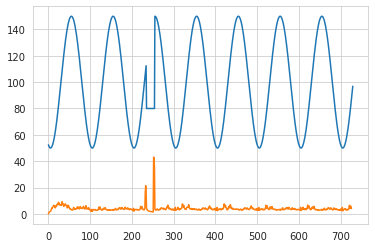

In [21]:
plt.plot(sin)
plt.plot(avg_codisp.values())

### Conclusion

- Trop long
- Implentation non réussi sur une station

## lsanomaly [OLD]

In [22]:
from lsanomaly import LSAnomaly

In [24]:
# Lecture du fichier activité
STATION_ID = 32  # Victoire
FEATURES_TO_USE = ["consecutive_no_transactions_out", "Sin_weekday", "Cos_weekday", "Sin_hours", "Cos_hours"]
ts_activity = read_time_serie_activity(path_directory=ROOT_DATA_CLEAN)

ts_activity = get_consecutive_no_transactions_out(ts_activity)
ts_activity = ts_activity[ts_activity["station_id"] == STATION_ID]

In [27]:
# Feature engi for cluster
X = process_data_cluster(ts_activity)

# Filter data based on time & event
X = filter_periode(X, NON_USE_STATION_ID=NON_USE_STATION_ID)

In [28]:
# Scaler
clf_scaler = StandardScaler()
# clf_scaler = RobustScaler()
# At train time lsanomaly calculates parameters rho and sigma
# lsanomaly = LSAnomaly(sigma=3, rho=0.1)
# lsanomaly = LSAnomaly(sigma=2, rho=0.2)
lsanomaly = LSAnomaly(sigma=1)

pipe = Pipeline([("scale", clf_scaler), ("pca", PCA(n_components=0.9)), ("cluster", lsanomaly)])

pipe.fit(X[FEATURES_TO_USE].values)

Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA(n_components=0.9)),
                ('cluster',
                 LSAnomaly(gamma=1.0,
                           kernel_pos=array([[-0.643054  ,  1.14338252, -0.29268547,  0.98042814,  1.17454111],
       [-0.27647367, -0.13627401, -1.43331984,  1.36091183, -0.65943197],
       [-0.40670509, -0.15789003,  1.36333726,  1.45156078, -0.52924032],
       ...,
       [-0.66613761, -0.1245376 ,  1.33939858,  1.45282183, -0.26981528],
       [ 0.53869382,  1.30053554, -0.76089788, -0.21826064, -1.29317192],
       [-0.48676062, -1.36680622,  1.40603825, -0.39591412, -0.4409556 ]]),
                           rho=0.1, sigma=1))])

In [33]:
ts_activity["anomaly"] = pipe.predict(ts_activity[FEATURES_TO_USE].values)
ts_activity["anomaly_proba"] = pipe.predict_proba(ts_activity[FEATURES_TO_USE].values)[:, 1]

In [34]:
ts_activity["anomaly"].value_counts()

0.0        87877
anomaly     3778
Name: anomaly, dtype: int64

In [ ]:
max_value = ts_activity["consecutive_no_transactions_out"].max()
ts_activity["anomaly_score"] = 0
ts_activity.loc[ts_activity["anomaly"] == "anomaly", "anomaly_score"] = max_value

ts_activity["anomaly_proba_fix"] = ts_activity["anomaly_proba"] * 100

plot_station_activity(
    ts_activity,
    features_to_plot=["consecutive_no_transactions_out", "anomaly_score", "anomaly_proba_fix"],
    station_id=STATION_ID,
)

In [37]:
ts_activity[ts_activity["anomaly"] == "anomaly"]["anomaly_proba"].describe()

count    3778.000000
mean        0.865645
std         0.161373
min         0.500816
25%         0.737812
50%         0.955830
75%         0.999998
max         1.000000
Name: anomaly_proba, dtype: float64

### Conclusion 

- Marche correctement (VS Iso Forest)
- Scikit friendly
- Possibilité d'afficher un score de probabilité d'anomaly.
- Paramétrage de `sigma` & `rho` rendant compliqué la généralisation du learning sur différentes stations.